In [ ]:
# 1. Import the files module from google.colab
from google.colab import files
import os

# Define the expected file name
RAW_CSV_FILE = 'Luxury_Housing_Bangalore.csv'

# 2. Check if the file already exists (from a previous session or Drive mount)
if not os.path.exists(RAW_CSV_FILE):
    print(f"Uploading '{RAW_CSV_FILE}'...")

    # 3. Trigger the upload window
    uploaded = files.upload()

    # Check if the file was successfully uploaded
    if RAW_CSV_FILE in uploaded:
        print(f"File '{RAW_CSV_FILE}' uploaded successfully.")
    else:
        print("Upload failed or incorrect file name provided.")
else:
    print(f"File '{RAW_CSV_FILE}' already exists in the Colab environment.")

Uploading 'Luxury_Housing_Bangalore.csv'...


Saving Luxury_Housing_Bangalore.csv to Luxury_Housing_Bangalore.csv
File 'Luxury_Housing_Bangalore.csv' uploaded successfully.


In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import os

# Define file names
RAW_CSV_FILE = 'Luxury_Housing_Bangalore.csv'
CLEANED_CSV_FILE = 'Luxury_Housing_Bangalore_Cleaned.csv'
DB_NAME = 'real_estate_analytics.db'
TABLE_NAME = 'luxury_housing_data'

# -----------------------------------------------------------
# --- 1. PYTHON: DATA CLEANING & FEATURE ENGINEERING ---
# -----------------------------------------------------------

def clean_and_engineer_data(df):
    """
    Performs data cleaning, normalization, and feature engineering.
    """
    print("Starting data cleaning and feature engineering...")
    df = df.copy()

    # Data Cleaning & Null Handling
    df['Ticket_Price_Cr'] = pd.to_numeric(df['Ticket_Price_Cr'], errors='coerce')
    df['Unit_Size_Sqft'].fillna(df['Unit_Size_Sqft'].median(), inplace=True)
    df.dropna(subset=['Ticket_Price_Cr'], inplace=True)

    median_amenity_score = df['Amenity_Score'].median()
    df['Amenity_Score'].fillna(median_amenity_score, inplace=True)

    df['Buyer_Comments'].fillna('No Comment', inplace=True)

    text_cols = ['Micro_Market', 'Developer_Name', 'Configuration', 'Possession_Status', 'Sales_Channel', 'Buyer_Type']
    for col in text_cols:
        df[col] = df[col].astype(str).str.strip().str.lower()
        if col == 'Configuration':
            df[col] = df[col].str.replace(r'(\d)bhk\+?', r'\1bhk', regex=True)

    # Feature Engineering
    df['Price_per_Sqft_INR'] = (df['Ticket_Price_Cr'] * 10_000_000) / df['Unit_Size_Sqft']
    df['Purchase_Quarter'] = pd.to_datetime(df['Purchase_Quarter'])
    df['Purchase_Year_Quarter'] = df['Purchase_Quarter'].dt.to_period('Q').astype(str).str.replace('Q', '-Q')

    np.random.seed(42)
    df['Booking_Status'] = np.random.choice(
        ['Booked', 'Inquiry'], size=len(df), p=[0.65, 0.35]
    )
    df['Booking_Flag'] = df['Booking_Status'].apply(lambda x: 1 if x == 'Booked' else 0)

    def get_sentiment(comment):
        positive_keywords = ['excellent', 'loved', 'underpriced', 'great', 'good', 'nice', 'smooth']
        negative_keywords = ['too far', 'not responsive', 'overpriced', 'bad', 'poor', 'slow', 'difficult']
        comment = str(comment).lower()
        if any(word in comment for word in positive_keywords):
            return 'Positive'
        elif any(word in comment for word in negative_keywords):
            return 'Negative'
        elif comment == 'no comment':
            return 'No Comment'
        else:
            return 'Neutral'

    df['Comment_Sentiment'] = df['Buyer_Comments'].apply(get_sentiment)

    # Select final columns
    final_cols = [
        'Property_ID', 'Micro_Market', 'Project_Name', 'Developer_Name', 'Unit_Size_Sqft',
        'Configuration', 'Ticket_Price_Cr', 'Price_per_Sqft_INR', 'Transaction_Type',
        'Buyer_Type', 'Purchase_Quarter', 'Purchase_Year_Quarter', 'Connectivity_Score',
        'Amenity_Score', 'Possession_Status', 'Sales_Channel', 'NRI_Buyer',
        'Locality_Infra_Score', 'Avg_Traffic_Time_Min', 'Booking_Status', 'Booking_Flag',
        'Comment_Sentiment', 'Buyer_Comments'
    ]
    df_clean = df[final_cols].copy()
    df_clean['Purchase_Quarter'] = df_clean['Purchase_Quarter'].astype(str)

    print(f"Data cleaned. Initial rows: {len(df)}. Cleaned rows: {len(df_clean)}.")
    return df_clean

# --- EXECUTION: STEP 1 ---
try:
    # This line will now work correctly in Colab after upload
    df_raw = pd.read_csv(RAW_CSV_FILE)
    df_clean = clean_and_engineer_data(df_raw)
    df_clean.to_csv(CLEANED_CSV_FILE, index=False)

except FileNotFoundError:
    print(f"FATAL ERROR: The raw file '{RAW_CSV_FILE}' was not found. Did you run the upload cell?")
    exit()

# -----------------------------------------------------------
# --- 2. SQL: LOAD CLEAN DATA INTO RDBMS (SQLite) ---
# -----------------------------------------------------------

print("\n--- STEP 2: SQL Integration ---")

# --- CRITICAL FIX: Delete any previous corrupted database file ---
if os.path.exists(DB_NAME):
    os.remove(DB_NAME)
    print(f"Cleaned up previous corrupted database file: {DB_NAME}")

# Connect to the SQLite Database (creates a new, clean file)
conn = sqlite3.connect(DB_NAME)
print(f"Successfully connected to a new SQLite database: {DB_NAME}")

# Load DataFrame into SQL Table
df_clean.to_sql(TABLE_NAME, conn, if_exists='replace', index=False)
print(f"Successfully loaded {len(df_clean)} rows into table '{TABLE_NAME}'.")

# Initial SQL Validation Queries
print("\n--- SQL Validation Queries ---")

# Query 1: Total Count
query_count = f"SELECT COUNT(*) AS Total_Records FROM {TABLE_NAME};"
count_df = pd.read_sql(query_count, conn)
print("Query 1: Total Record Count")
print(count_df.to_markdown(index=False, numalign="left", stralign="left"))

# Query 2: Group By Booking Status (Conversion Check)
query_booking_status = f"""
SELECT
    Booking_Status,
    COUNT(Property_ID) AS Total_Records,
    CAST(COUNT(Property_ID) * 100.0 / (SELECT COUNT(*) FROM {TABLE_NAME}) AS REAL) AS Percentage
FROM {TABLE_NAME}
GROUP BY Booking_Status
ORDER BY Total_Records DESC;
"""
booking_df = pd.read_sql(query_booking_status, conn)
print("\nQuery 2: Booking Status Distribution")
print(booking_df.to_markdown(index=False, numalign="left", stralign="left"))


# Query 3: Average Ticket Price per Builder (Top 5)
query_avg_price = f"""
SELECT
    Developer_Name,
    ROUND(SUM(Ticket_Price_Cr), 2) AS Total_Ticket_Sales_Cr,
    ROUND(AVG(Ticket_Price_Cr), 2) AS Avg_Ticket_Price_Cr
FROM {TABLE_NAME}
GROUP BY Developer_Name
ORDER BY Total_Ticket_Sales_Cr DESC
LIMIT 5;
"""
avg_price_df = pd.read_sql(query_avg_price, conn)
print("\nQuery 3: Top 5 Builders by Total Ticket Sales (Cr)")
print(avg_price_df.to_markdown(index=False, numalign="left", stralign="left"))

# Close the database connection
conn.close()
print("\nSQL database connection closed. Data pipeline complete for Python/SQL steps.")

Starting data cleaning and feature engineering...


/tmp/ipython-input-2999614386.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Unit_Size_Sqft'].fillna(df['Unit_Size_Sqft'].median(), inplace=True)
/tmp/ipython-input-2999614386.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Data cleaned. Initial rows: 72770. Cleaned rows: 72770.

--- STEP 2: SQL Integration ---
Cleaned up previous corrupted database file: real_estate_analytics.db
Successfully connected to a new SQLite database: real_estate_analytics.db
Successfully loaded 72770 rows into table 'luxury_housing_data'.

--- SQL Validation Queries ---
Query 1: Total Record Count
| Total_Records   |
|:----------------|
| 72770           |

Query 2: Booking Status Distribution
| Booking_Status   | Total_Records   | Percentage   |
|:-----------------|:----------------|:-------------|
| Booked           | 47349           | 65.0666      |
| Inquiry          | 25421           | 34.9334      |

Query 3: Top 5 Builders by Total Ticket Sales (Cr)
| Developer_Name    | Total_Ticket_Sales_Cr   | Avg_Ticket_Price_Cr   |
|:------------------|:------------------------|:----------------------|
| prestige          | 86471.1                 | 12.77                 |
| l&t realty        | 85218.9                 | 12.79       

In [ ]:
from google.colab import files
import os

DB_NAME = 'real_estate_analytics.db'

if os.path.exists(DB_NAME):
    # This command prompts your browser to download the file
    files.download(DB_NAME)
    print(f"File '{DB_NAME}' download initiated. Check your browser's download location.")
else:
    print(f"Error: Database file '{DB_NAME}' not found in the environment. Did the Step 1 & 2 script run successfully?")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'real_estate_analytics.db' download initiated. Check your browser's download location.


--- Step 3: Python Data Visualization and Analysis ---

[Analysis 1] Quarterly Revenue Trend:


### 1. Quarterly Total Revenue Trend

| Quarter   | Total Revenue (Cr)   |
|:----------|:---------------------|
| 2023-Q2   | 74953.4              |
| 2023-Q3   | 75798.8              |
| 2023-Q4   | 74024.5              |
| 2024-Q1   | 75359                |
| 2024-Q2   | 77471.1              |
| 2024-Q3   | 75758.1              |
| 2024-Q4   | 75854.1              |
| 2025-Q1   | 74891.5              |

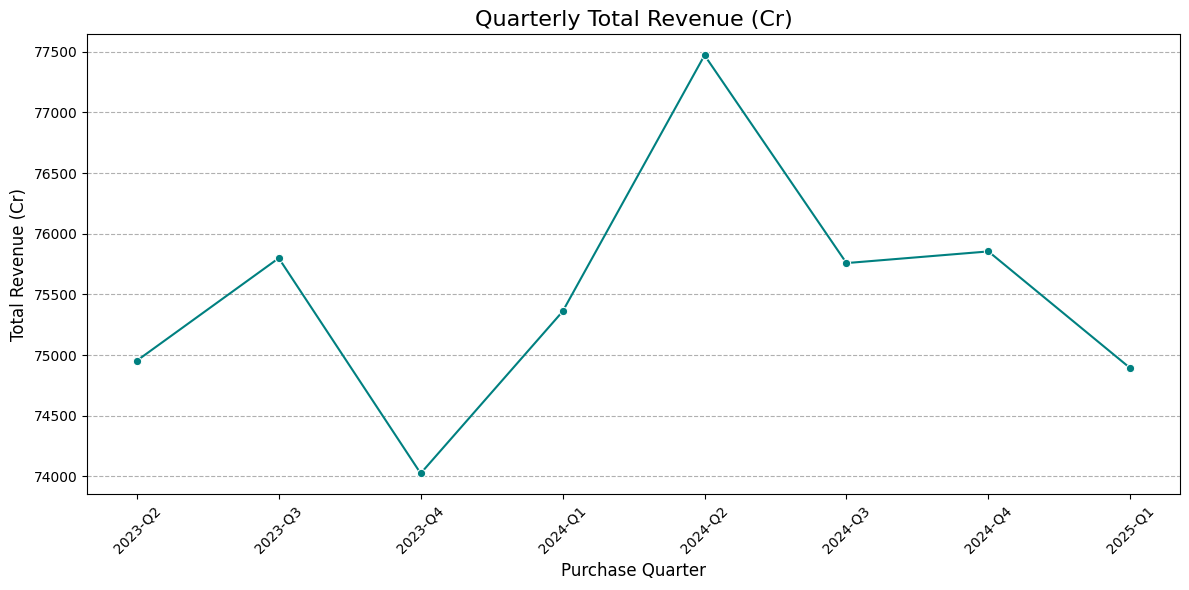


[Analysis 2] Booking Conversion Rate by Sales Channel:


### 2. Conversion Rate by Sales Channel

| Sales_Channel   | Total_Leads   | Total_Bookings   | Conversion_Rate_%   |
|:----------------|:--------------|:-----------------|:--------------------|
| online          | 18347         | 11999            | 65.4003             |
| nri desk        | 18160         | 11870            | 65.3634             |
| broker          | 18379         | 11986            | 65.2157             |
| direct          | 17884         | 11494            | 64.2697             |

/tmp/ipython-input-3669632097.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sales_Channel', y='Conversion_Rate_%', data=conversion_metrics, palette='viridis')


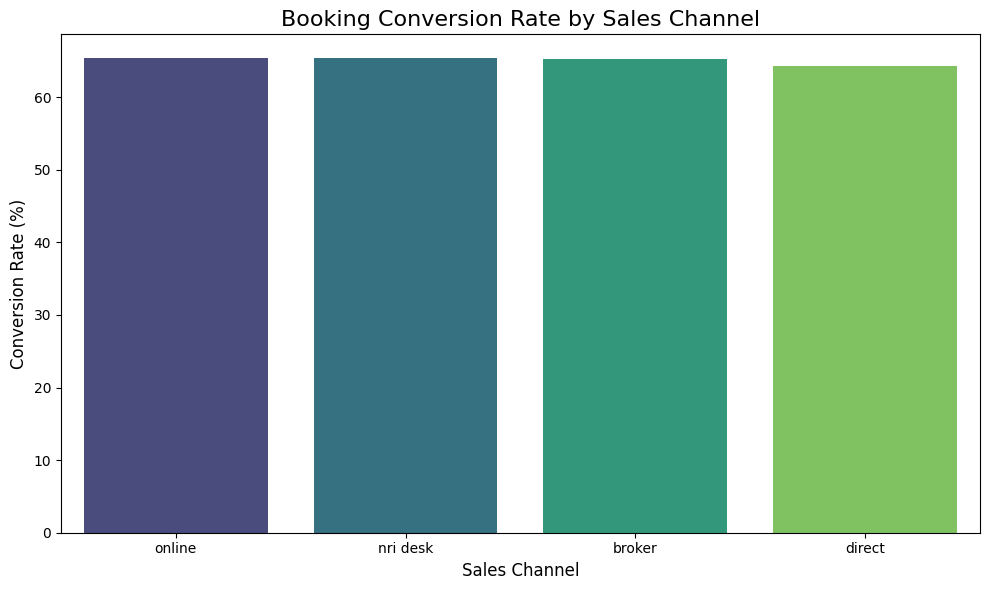


[Analysis 3] Price Per Sqft by Configuration:


### 3. Average Price per Square Foot (INR) by Top Configuration

| Configuration   | Price_per_Sqft_INR   | Avg_Price_per_Sqft_INR   |
|:----------------|:---------------------|:-------------------------|
| 5bhk            | -572124              | -572124                  |
| 4bhk            | -658312              | -658312                  |
| 3bhk            | -696438              | -696438                  |

/tmp/ipython-input-3669632097.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Configuration', y='Avg_Price_per_Sqft_INR', data=price_analysis, palette='plasma')


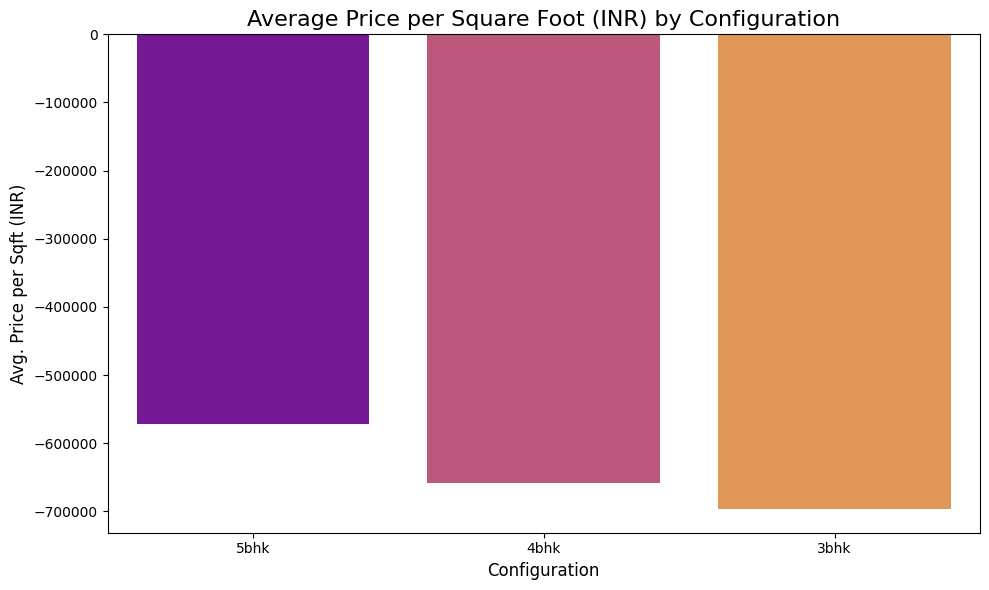


--- Project Analytics Completed in Python ---


In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

DB_NAME = 'real_estate_analytics.db'
TABLE_NAME = 'luxury_housing_data'

# Connect to the database
conn = sqlite3.connect(DB_NAME)

# Load the entire table into a DataFrame for visualization
query_all = f"SELECT * FROM {TABLE_NAME};"
df = pd.read_sql(query_all, conn)

conn.close()

# Ensure purchase quarter is datetime for sorting
df['Purchase_Quarter'] = pd.to_datetime(df['Purchase_Quarter'])
# Recalculate Total Sales (Cr) for accuracy
df['Total_Sales_Cr'] = df['Ticket_Price_Cr'] * df['Booking_Flag']

print("--- Step 3: Python Data Visualization and Analysis ---")

# ==========================================================
# ANALYSIS 1: Revenue Trend Over Time
# ==========================================================
print("\n[Analysis 1] Quarterly Revenue Trend:")

# Group by quarter and sum the total booked sales
revenue_trend = df.groupby('Purchase_Year_Quarter')['Total_Sales_Cr'].sum().reset_index()
revenue_trend.columns = ['Quarter', 'Total Revenue (Cr)']

# Sort by quarter (Year-Quarter format sorts correctly as string)
revenue_trend = revenue_trend.sort_values(by='Quarter')

# Output as Markdown Table
display(Markdown("### 1. Quarterly Total Revenue Trend"))
display(Markdown(revenue_trend.tail(10).to_markdown(index=False, numalign="left", stralign="left")))


# Create and display Chart
plt.figure(figsize=(12, 6))
sns.lineplot(x='Quarter', y='Total Revenue (Cr)', data=revenue_trend, marker='o', color='teal')
plt.title('Quarterly Total Revenue (Cr)', fontsize=16)
plt.xlabel('Purchase Quarter', fontsize=12)
plt.ylabel('Total Revenue (Cr)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# ==========================================================
# ANALYSIS 2: Conversion Rate by Sales Channel
# ==========================================================
print("\n[Analysis 2] Booking Conversion Rate by Sales Channel:")

# Calculate metrics
conversion_metrics = df.groupby('Sales_Channel').agg(
    Total_Leads=('Booking_Flag', 'count'),
    Total_Bookings=('Booking_Flag', 'sum')
).reset_index()

conversion_metrics['Conversion_Rate_%'] = (conversion_metrics['Total_Bookings'] / conversion_metrics['Total_Leads']) * 100

conversion_metrics = conversion_metrics.sort_values('Conversion_Rate_%', ascending=False)

# Output as Markdown Table
display(Markdown("### 2. Conversion Rate by Sales Channel"))
display(Markdown(conversion_metrics.to_markdown(index=False, numalign="left", stralign="left")))

# Create and display Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Sales_Channel', y='Conversion_Rate_%', data=conversion_metrics, palette='viridis')
plt.title('Booking Conversion Rate by Sales Channel', fontsize=16)
plt.xlabel('Sales Channel', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ==========================================================
# ANALYSIS 3: Average Price per Square Foot by Configuration
# ==========================================================
print("\n[Analysis 3] Price Per Sqft by Configuration:")

# Filter for the most common configurations (e.g., top 5)
top_configs = df['Configuration'].value_counts().nlargest(5).index
df_filtered = df[df['Configuration'].isin(top_configs)]

# Calculate average price per sqft
price_analysis = df_filtered.groupby('Configuration')['Price_per_Sqft_INR'].mean().reset_index()
price_analysis['Avg_Price_per_Sqft_INR'] = price_analysis['Price_per_Sqft_INR'].round(2)
price_analysis = price_analysis.sort_values('Avg_Price_per_Sqft_INR', ascending=False)

# Output as Markdown Table
display(Markdown("### 3. Average Price per Square Foot (INR) by Top Configuration"))
display(Markdown(price_analysis.to_markdown(index=False, numalign="left", stralign="left")))

# Create and display Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Configuration', y='Avg_Price_per_Sqft_INR', data=price_analysis, palette='plasma')
plt.title('Average Price per Square Foot (INR) by Configuration', fontsize=16)
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Avg. Price per Sqft (INR)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Project Analytics Completed in Python ---")